In [8]:
def make_dwt_vars(wells_df,logs,levels,wavelet='db3'):

    from scipy.interpolate import interp1d
    import pywt
    
    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
        
            for i in range(1,max_level+1):

                cA,cD = pywt.dwt(temp_data,wave,mode='symmetric')
                new_depth = np.linspace(min(depth),max(depth),len(cD))
                f = interp1d(new_depth,cD,kind='nearest')
                f1 = interp1d(new_depth,cA,kind='linear')

                
                if (i in levels):
                    temp_df[log + '_cD_step_level_' + str(i)] = f(depth)
                    temp_df[log + '_cA_level_' + str(i)] = f1(depth)
                
                temp_data = f1(depth)
                
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [9]:
def make_entropy_vars(wells_df,logs,l_foot):
    
    from skimage.filters.rank import entropy
    from skimage.morphology import rectangle
    from skimage.util import img_as_ubyte
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]       
            footprint = rectangle(l_foot,3)

            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)

            temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [10]:
def make_gradient_vars(wells_df,logs,dx_list):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth

        for log in logs:

            temp_data = grouped.get_group(key)[log]

            for dx in dx_list:

                temp_df[log + 'gradient_dx' + str(dx)] = np.gradient(temp_data,dx)

        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df) 
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 20)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [12]:
toto = make_dwt_vars(training_data,['GR'],[1,2,3,4,5])
toto



,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,GR_cD_step_level_1,GR_cA_level_1,GR_cD_step_level_2,GR_cA_level_2,GR_cD_step_level_3,GR_cA_level_3,GR_cD_step_level_4,GR_cA_level_4,GR_cD_step_level_5,GR_cA_level_5
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,...,0.062591,114.100501,0.488774,155.472870,-0.702469,227.306379,0.901536,312.145161,-1.133676,453.088214
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,...,-1.930541,111.961674,-1.105809,158.337098,1.898403,223.676644,-2.504428,316.696347,3.168743,447.395729
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,...,-1.930541,109.859083,-1.105809,161.131096,1.898403,220.141037,-2.504428,321.128025,3.168743,441.853168
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,...,-5.282836,109.867183,-0.716684,159.834163,-0.389437,222.088442,1.037686,318.598354,-1.472910,445.043669
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,...,-5.282836,109.986891,-0.716684,158.510496,-0.389437,224.016702,1.037686,316.109560,-1.472910,448.177558
5,3,A1 SH,SHRIMPLIN,2795.5,73.970,0.636,14.000,13.385,3.600,1,...,0.372386,113.301358,3.370826,156.421593,-1.834375,225.396935,1.301915,314.790856,-1.134029,449.690934
6,3,A1 SH,SHRIMPLIN,2796.0,73.720,0.630,15.600,13.930,3.700,1,...,0.372386,116.145214,3.370826,154.613880,-1.834375,226.549475,1.301915,313.688340,-1.134029,450.960422
7,3,A1 SH,SHRIMPLIN,2796.5,75.650,0.625,16.500,13.920,3.500,1,...,-1.833992,110.165127,-3.291351,158.078470,2.643460,223.432767,-2.092871,316.639324,2.055216,447.657028
8,3,A1 SH,SHRIMPLIN,2797.0,73.790,0.624,16.200,13.980,3.400,1,...,-1.833992,104.611489,-3.291351,161.136268,2.643460,220.634755,-2.092871,319.272425,2.055216,444.690155
9,3,A1 SH,SHRIMPLIN,2797.5,76.890,0.615,16.900,14.220,3.500,1,...,0.216925,104.948178,0.587143,158.575246,-0.423929,222.238732,0.919046,317.514752,-0.902538,446.371480


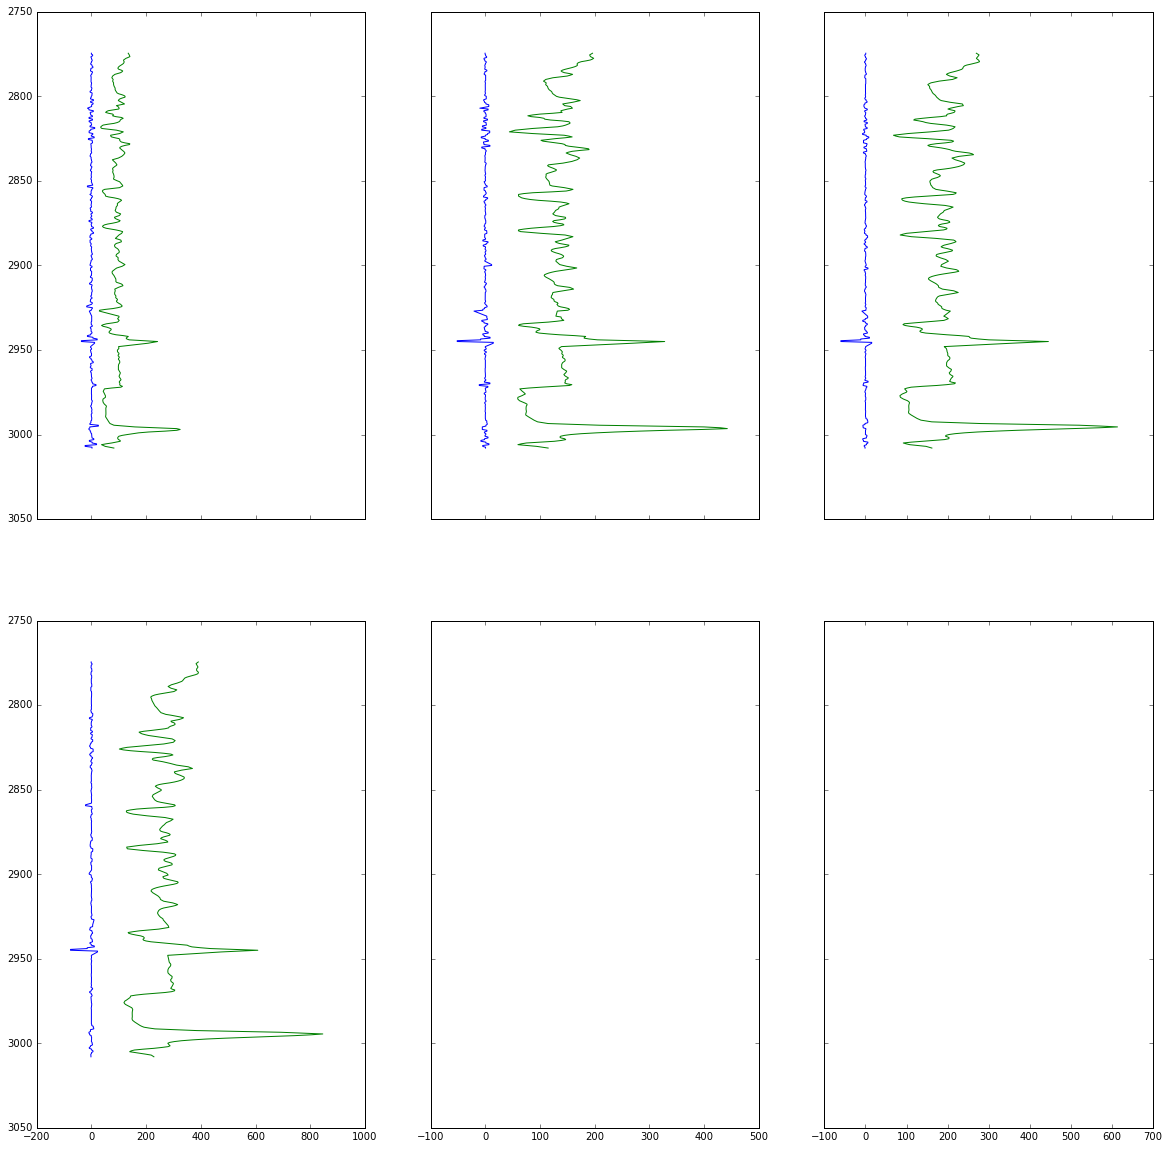

In [21]:
fig, axs = plt.subplots(figsize=(20,20), 
                        nrows=2, ncols=3, 
                        #gridspec_kw=dict(hspace=0.4),
                        sharey='row',sharex='col')
for i in range(2):
    axs[i,0].invert_yaxis()

for i,ax in zip(range(1,5),axs.flatten()):
    data=toto[toto['Well Name']=='SHANKLE']
    ax.plot(data['GR_cD_step_level_'+str(i)],data.Depth)
    ax.plot(data['GR_cA_level_'+str(i)],data.Depth)

In [5]:
grouped = training_data.groupby(['Well Name'])

In [6]:
new_vars = pd.DataFrame()

for key in grouped.groups.keys():
    
    NM_M = grouped.get_group(key)['NM_M'].values
    
    temp_df = pd.DataFrame()
    temp_df['Depth'] = grouped.get_group(key)['Depth']
    temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        
    dh_1 = np.zeros(len(NM_M))
    dh_2 = np.zeros(len(NM_M))
    count1 = 0
    count2 = 0
    
    for i in range(len(NM_M)):
               
        if NM_M[i] == 1:
            
            count1=0
            count2+=0.5
            dh_2[i] += count2
            
        elif NM_M[i] == 2:
            
            count2=0
            count1+=0.5
            dh_1[i] += count1
    
    temp_df['dh_1'] = dh_1
    temp_df['dh_2'] = dh_2
        
    new_vars = new_vars.append(temp_df)

In [7]:
new_vars = new_vars.sort_index()
new_vars =new_vars.drop(['Well Name','Depth'],axis=1)
training_data =  pd.concat([training_data,new_vars],axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dh_1,dh_2
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,0.0,0.5
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,0.0,1.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,0.0,1.5
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,0.0,2.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,0.0,2.5
5,3,A1 SH,SHRIMPLIN,2795.5,73.970,0.636,14.000,13.385,3.600,1,0.894,0.0,3.0
6,3,A1 SH,SHRIMPLIN,2796.0,73.720,0.630,15.600,13.930,3.700,1,0.872,0.0,3.5
7,3,A1 SH,SHRIMPLIN,2796.5,75.650,0.625,16.500,13.920,3.500,1,0.830,0.0,4.0
8,3,A1 SH,SHRIMPLIN,2797.0,73.790,0.624,16.200,13.980,3.400,1,0.809,0.0,4.5
9,3,A1 SH,SHRIMPLIN,2797.5,76.890,0.615,16.900,14.220,3.500,1,0.787,0.0,5.0


In [8]:
new_vars = pd.DataFrame()

for key in grouped.groups.keys():
    
    NM_M = grouped.get_group(key)['NM_M'].values
    
    temp_df = pd.DataFrame()
    temp_df['Depth'] = grouped.get_group(key)['Depth']
    temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        
    db_1 = np.zeros(len(NM_M))
    db_2 = np.zeros(len(NM_M))
    count1 = 0
    count2 = 0
    
    for i in range(len(NM_M)-1,-1,-1):
               
        if NM_M[i] == 1:
            
            count1=0
            count2+=0.5
            db_2[i] += count2
            
        elif NM_M[i] == 2:
            
            count2=0
            count1+=0.5
            db_1[i] += count1
    
    temp_df['db_1'] = db_1
    temp_df['db_2'] = db_2
        
    new_vars = new_vars.append(temp_df)

In [9]:
new_vars = new_vars.sort_index()
new_vars = new_vars.drop(['Well Name','Depth'],axis=1)
training_data =  pd.concat([training_data,new_vars],axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dh_1,dh_2,db_1,db_2
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,0.0,0.5,0.0,21.5
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,0.0,1.0,0.0,21.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,0.0,1.5,0.0,20.5
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,0.0,2.0,0.0,20.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,0.0,2.5,0.0,19.5
5,3,A1 SH,SHRIMPLIN,2795.5,73.970,0.636,14.000,13.385,3.600,1,0.894,0.0,3.0,0.0,19.0
6,3,A1 SH,SHRIMPLIN,2796.0,73.720,0.630,15.600,13.930,3.700,1,0.872,0.0,3.5,0.0,18.5
7,3,A1 SH,SHRIMPLIN,2796.5,75.650,0.625,16.500,13.920,3.500,1,0.830,0.0,4.0,0.0,18.0
8,3,A1 SH,SHRIMPLIN,2797.0,73.790,0.624,16.200,13.980,3.400,1,0.809,0.0,4.5,0.0,17.5
9,3,A1 SH,SHRIMPLIN,2797.5,76.890,0.615,16.900,14.220,3.500,1,0.787,0.0,5.0,0.0,17.0


In [2]:
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import ensemble

In [ ]:
#Assign category integer to Formation
Formation_list=np.unique(training_data.Formation)

for f,i in zip(Formation_)

In [1]:
id_NM = training_data.NM_M == 1
id_M = training_data.NM_M == 2

NM_training_data = training_data[id_NM]
M_training_data = training_data[id_M]

logs = ['PHIND','ILD_log10','DeltaPHI','GR']
dx=[10]
levels = [4]

# NM_training_data = make_dwt_vars(NM_training_data,['GR'],levels)
# NM_training_data = make_entropy_vars(NM_training_data,logs,20)
# NM_training_data = make_gradient_vars(NM_training_data,logs,dx)

# M_training_data = make_dwt_vars(M_training_data,['GR'],levels)
# M_training_data = make_entropy_vars(M_training_data,logs,20)
# M_training_data = make_gradient_vars(M_training_data,logs,dx)

NM_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
M_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)

M_training_data.describe()

NameError: name 'training_data' is not defined

In [28]:
nm_drop_list = ['Formation', 'Well Name', 'Depth',
                                     'Facies','db_1','dh_1','DeltaPHI','ILD_log10','PE','NM_M','RELPOS']
m_drop_list = ['Formation', 'Well Name', 'Depth',
                                      'Facies','db_1','dh_1','db_2','dh_2','PE','NM_M']

NM_training_data.drop(nm_drop_list,axis=1)

,GR,PHIND,dh_2,db_2
0,77.450,11.915,0.5,21.5
1,78.260,12.565,1.0,21.0
2,79.050,13.050,1.5,20.5
3,86.100,13.115,2.0,20.0
4,74.580,13.300,2.5,19.5
5,73.970,13.385,3.0,19.0
6,73.720,13.930,3.5,18.5
7,75.650,13.920,4.0,18.0
8,73.790,13.980,4.5,17.5
9,76.890,14.220,5.0,17.0


In [27]:
clf = ensemble.RandomForestClassifier(n_estimators=300,n_jobs=-1,max_depth=9)

for _ in range(1):
    names = list(np.unique(training_data['Well Name']))

    nm_grouped = NM_training_data.groupby(['Well Name'])
    m_grouped = M_training_data.groupby(['Well Name'])

    scores = []

    for name in names:


        if name == 'Recruit F9':

            #Build list of well names and remove blind well (and remove recruit F9 for NM)
            m_train_names = names.copy()
            m_train_names.remove(name)

            # Do it for marine sediments
            m_test = m_grouped.get_group(name)
            m_X_test = m_test.drop(m_drop_list, axis=1).values
            y_test = m_test['Facies'].values

            m_train = pd.DataFrame()

            for train_name in m_train_names:
                m_train = m_train.append(m_grouped.get_group(train_name))

            id_train_M = m_train.Facies >= 4
            m_train = m_train [id_train_M]
            m_X_train = m_train.drop(m_drop_list, axis=1).values
            m_y_train = m_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
            smt = SMOTE()
            m_X_train, m_y_train = smt.fit_sample(m_X_train,m_y_train)

            #Then we do random forest classification
            clf.fit(m_X_train, m_y_train)
            y_pred = clf.predict(m_X_test)

        else:

            #Build list of well names and remove blind well (and remove recruit F9 for NM)
            m_train_names = names.copy()
            m_train_names.remove(name)   

            nm_train_names = m_train_names.copy()
            nm_train_names.remove('Recruit F9')


            # Do it for non-marine sediments
            nm_test = nm_grouped.get_group(name)
            nm_X_test = nm_test.drop(nm_drop_list, axis=1).values
            nm_y_test = nm_test['Facies'].values

            nm_train = pd.DataFrame()

            for train_name in nm_train_names:
                nm_train = nm_train.append(nm_grouped.get_group(train_name))

            id_train_NM = nm_train.Facies <= 3
            nm_train = nm_train [id_train_NM]
            nm_X_train = nm_train.drop(nm_drop_list, axis=1).values
            nm_y_train = nm_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
            smt = SMOTE()
            nm_X_train, nm_y_train = smt.fit_sample(nm_X_train,nm_y_train)

            #Then we do random forest classification
            clf.fit(nm_X_train, nm_y_train)
            nm_y_pred = clf.predict(nm_X_test)
            
            print(clf.feature_importances_)

            #*********************************************************************#

            # Do it for marine sediments
            m_test = m_grouped.get_group(name)
            m_X_test = m_test.drop(m_drop_list, axis=1).values
            m_y_test = m_test['Facies'].values

            m_train = pd.DataFrame()

            for train_name in m_train_names:
                m_train = m_train.append(m_grouped.get_group(train_name))

            id_train_M = m_train.Facies >= 4
            m_train = m_train [id_train_M]
            m_X_train = m_train.drop(m_drop_list, axis=1).values
            m_y_train = m_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
            smt = SMOTE()
            m_X_train, m_y_train = smt.fit_sample(m_X_train,m_y_train)

            #Then we do random forest classification
            clf.fit(m_X_train, m_y_train)
            m_y_pred = clf.predict(m_X_test)
            
            print(clf.feature_importances_)

            #================================================================#
            #                         combine results
            #================================================================#

            y_test = np.hstack((nm_y_test,m_y_test))
            y_pred = np.hstack((nm_y_pred,m_y_pred))

        #Scoring
        conf_mat = metrics.confusion_matrix(y_test,y_pred)
#         print(conf_mat)
        try:
            score = metrics.f1_score(y_test, y_pred,average='weighted')
        except:
            score = conf_mat[1,1]/np.sum(conf_mat)
        scores.append(score)
        print('********')
        print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))
        

    print("="*30)
    print('*********** RESULT ***********')
    print("="*30)
    print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[ 0.20890717  0.21720491  0.28762252  0.2862654 ]
[ 0.21952274  0.25041725  0.18220922  0.18385742  0.16399337]
********
Blind well is ALEXANDER D, F1 score : 58.2717%

[ 0.22007251  0.22043685  0.28173041  0.27776023]
[ 0.21972315  0.26441686  0.17417964  0.17728047  0.16439988]
********
Blind well is CHURCHMAN BIBLE, F1 score : 56.2807%

[ 0.22108145  0.20531331  0.32112802  0.25247722]
[ 0.21539328  0.24764267  0.17694585  0.18545326  0.17456495]
********
Blind well is CROSS H CATTLE, F1 score : 52.1808%

[ 0.23199095  0.21804012  0.29296216  0.25700677]
[ 0.22600491  0.2520054   0.17588989  0.17561964  0.17048016]
********
Blind well is KIMZEY A, F1 score : 51.1451%

[ 0.21763744  0.20885521  0.29274152  0.28076583]
[ 0.23334997  0.23367851  0.17651216  0.18222467  0.17423469]
********
Blind well is LUKE G U, F1 score : 62.0640%

[ 0.23617965  0.2211107   0.28005232  0.26265733]
[ 0.22131172  0.23943233  0.17341521  0.1929432   0.17289755]
********
Blind well is NEWBY, F1 score : 5